# Trying a Hurdle Model with XGBoost

In [1]:
# Load the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import seaborn as sns

df = pd.read_csv('~/Downloads/eurovision_merged_covariates_03Feb.csv')

In [2]:
df.head()

,Unnamed: 0,Year,From country,Votes,Country,Own,English,Other,has_border,migration_band,migration_year,code,code3,population,count,prop_emigrants,Gender,comps_since_last_win
0,0,1999,AT,12.0,Bosnia and Herzegovina,0.0,0.0,1.0,NaN,2000,2000,BA,BIH,4179350.0,273,0.000065,group,43
1,1,1999,AT,0.0,Belgium,0.0,1.0,0.0,NaN,2000,2000,BE,BEL,10251250.0,2486,0.000243,female,12
2,2,1999,AT,0.0,Cyprus,1.0,0.0,0.0,NaN,2000,2000,CY,CYP,948237.0,161,0.000170,female,43
3,3,1999,AT,10.0,Germany,0.0,0.0,1.0,1.0,2000,2000,DE,DEU,82211508.0,181487,0.002208,group,16
4,4,1999,AT,5.0,Denmark,0.0,1.0,0.0,NaN,2000,2000,DK,DNK,5339616.0,1525,0.000286,group,35


View the voting as a network

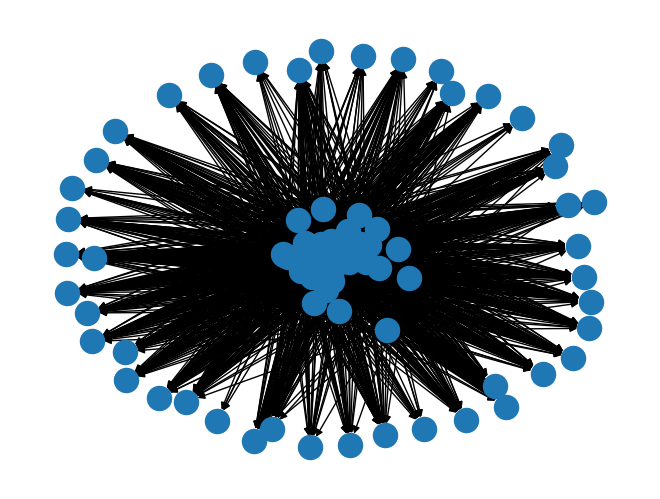

In [3]:
import networkx as nx

# convert the data to a network
def convert_to_network(df):
    network = collections.defaultdict(dict)
    for _, row in df.iterrows():
        network[row['From country']][row['Country']] = int(row['Votes'])
    return network

network = convert_to_network(df)

# create a graph of the network

def create_graph(network):
    G = nx.DiGraph()
    for country, votes in network.items():
        for vote, count in votes.items():
            G.add_edge(country, vote, weight=count)
    return G

network2 = create_graph(network)



nx.draw(network2)

# XGBoost to predict if score given

First step in the hurdle model.

Example: https://www.kaggle.com/code/sriharinitumu/light-gbm-with-hurdle-modelling

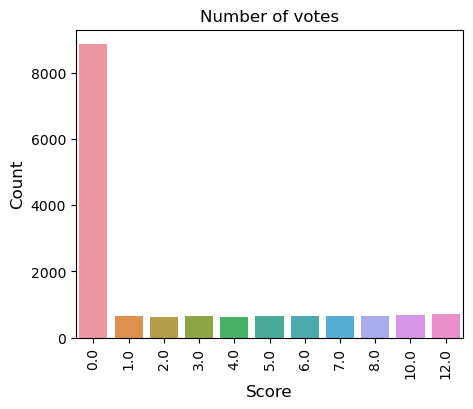

In [4]:
# Bar chart for vote occurrences
plt.figure(figsize=(5,4))
sns.countplot(x="Votes", data=df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Number of votes', fontsize=12)
plt.show()


As you can see we have a lot of zeroes....this probably makes this problem appropriate for a hurdle model. Where we first decide if a score is given, and then if it is, we predict the score.

In [5]:
df_xgboost = df[['Year', 'From country', 'Votes', 'Own',
       'English', 'Other', 'has_border', 
       'code', 'prop_emigrants', 'Gender', 'comps_since_last_win']]

df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)
df_xgboost['received_vote'] = df_xgboost['Votes'].apply(lambda x: 1 if x > 0 else 0)

df_xgboost.head()

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/696519571.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['has_border'] = df_xgboost['has_border'].fillna(0)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/696519571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xgboost['received_vote'] = df_xgboost['Votes'].apply(lambda x: 1 if x > 0 else 0)


,Year,From country,Votes,Own,English,Other,has_border,code,prop_emigrants,Gender,comps_since_last_win,received_vote
0,1999,AT,12.0,0.0,0.0,1.0,0.0,BA,0.000065,group,43,1
1,1999,AT,0.0,0.0,1.0,0.0,0.0,BE,0.000243,female,12,0
2,1999,AT,0.0,1.0,0.0,0.0,0.0,CY,0.000170,female,43,0
3,1999,AT,10.0,0.0,0.0,1.0,1.0,DE,0.002208,group,16,1
4,1999,AT,5.0,0.0,1.0,0.0,0.0,DK,0.000286,group,35,1


In [6]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

def basic_xgboost(df_input, seed, test_size, predictor_column='received_vote'):
    X = df_input[["Year", "From country", "code",
        "Own", "English", "Other", "has_border",   
        "prop_emigrants", "Gender", "Votes", "received_vote",
        "comps_since_last_win"]]
    Y = df_input[predictor_column]


    # one hot encode the gender, from country and code
    for j in ['Gender', 'From country', 'code']:
        j_text = '_voting' if j == 'From country' else ''
        for i in X[j].unique():
            output_binary = X[j].apply(lambda x: 1 if x == i else 0)
            X[i+j_text] = output_binary

        X = X[X.columns.drop(j)]

    # convert Y to int
    Y = Y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    test_all = X_test

    # remove 'Votes' and 'received_vote' columns from X_train
    X_train = X_train[X_train.columns.drop('Votes')]
    X_train = X_train[X_train.columns.drop('received_vote')]
    X_test = X_test[X_test.columns.drop('Votes')]
    X_test = X_test[X_test.columns.drop('received_vote')]

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    return model, X_test, y_test, test_all

def model_predictions(model, X_test, y_test):
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]

    X_test['predictions'] = predictions
    X_test['actual'] = y_test

    return X_test

def model_evalutation(df_pred):
    # evaluate predictions
    accuracy = accuracy_score(df_pred['actual'], df_pred['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # print a confusion matrix heatmap

    cm = confusion_matrix(df_pred['actual'], df_pred['predictions'])
    sns.heatmap(cm, annot=True, fmt="d")

    # add title and axis labels
    plt.title('Confusion matrix' + "(Accuracy={:.3f})".format(accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Accuracy: 76.14%


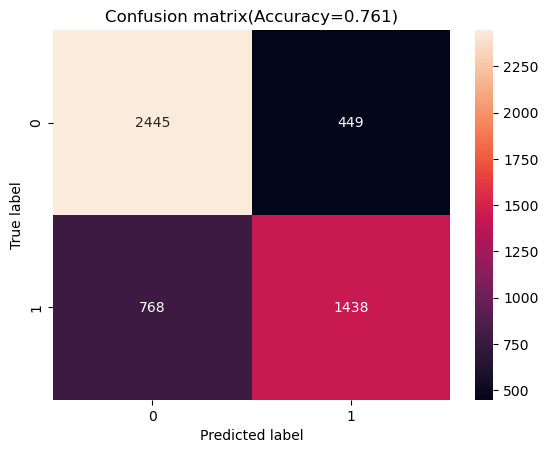

In [7]:
model_basic, X_test, y_test, test_all = basic_xgboost(df_xgboost, seed=7, test_size=0.33)
predictions = model_predictions(model_basic, X_test, y_test)
model_evalutation(predictions)

To view variable importance we can take a peak at the tree:

<AxesSubplot:>

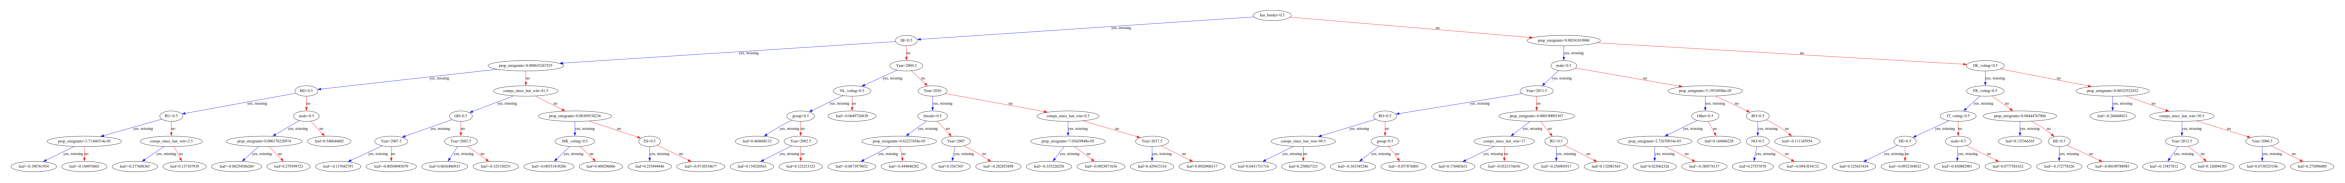

In [8]:
import matplotlib

graph = xgb.to_graphviz(model_basic, num_trees=1, rankdir='LR')

fig, ax = plt.subplots(figsize=(30, 50))
xgb.plot_tree(model_basic, num_trees=1, ax=ax)

First node = has_border !

## Ranking Score

So of those, lets subset to only those that have a score.

In [14]:
# subset to those with a score
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import spearmanr

def xgboost_rank_model(df_input, test_size=0.33, seed=7):

    df2 = df_input[["Year", "From country", "code",
            "Own", "English", "Other", "has_border",   
            "prop_emigrants", "Gender",
            "comps_since_last_win", "Votes"]]

    df2 = df2.loc[df2['Votes'] > 0]

    df2['has_border'] = df2['has_border'].fillna(0)
    df2 = df2.rename(columns={"Votes": 'rank'})
    #df2 = df2.rename(columns={"From country": 'id'})

    df2['rank'] = df2['rank'].astype(int) - 1

    df2['id'] = df2['From country'].astype(str) + df2['Year'].astype(str)

    # one hot encode the gender, from country and code
    for j in ['Gender', 'code', 'From country']:
        j_text = "_voting" if j == 'From country' else ''
        for i in df2[j].unique():
            df2[i+j_text] = df2[j].apply(lambda x: 1 if x == i else 0)

        df2 = df2[df2.columns.drop(j)]

    #df2= df2[df2.columns.drop('From country')]
    df2= df2[df2.columns.drop('Year')]

    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state = seed).split(df2, groups=df2['id'])

    X_train_inds, X_test_inds = next(gss)

    train_data= df2.iloc[X_train_inds]
    X_train = train_data.loc[:, ~train_data.columns.isin(['id','rank'])]
    y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

    groups = train_data.groupby('id').size().to_frame('size')['size'].to_numpy()

    test_data= df2.iloc[X_test_inds]
    test_data = test_data[X_train.columns.tolist() + ['rank', 'id']]

    #We need to keep the id for later predictions
    # X_test = test_data.loc[:, ~test_data.columns.isin(['rank'])]
    # y_test = test_data.loc[:, test_data.columns.isin(['rank'])]

    model = xgb.XGBRanker(  
        tree_method='hist',
        booster='gbtree',
        objective='rank:pairwise',
        random_state=7, 
        learning_rate=0.1,
        colsample_bytree=0.9, 
        eta=0.05, 
        max_depth=6, 
        n_estimators=110, 
        subsample=0.75 
    )

    model.fit(X_train, y_train, group=groups, verbose=True)

    return model, test_data, train_data

    predictions = (test_set.groupby('id').apply(lambda x: ranked_predict(model, x)))

    test_set['prediction_rel'] = np.nan

    for i in predictions.index:
        preds = predictions.loc[i]

        # get the order of the predictions
        #temp = sorted(preds)   
        res = rankdata(preds, method='ordinal')
        print(i)
        print(res)

        test_set.loc[test_set['id'] == i, 'prediction_rel'] = res

        # create a score for top 10 predictions getting 1:10 and others 0
        top10 = test_set.loc[test_set['id'] == i, 'prediction_rel'].nlargest(10).values


        test_set.loc[test_set['id'] == i, 'prediction'] = test_set.loc[test_set['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
        
        # if not zero subtract min(top10) 
        test_set.loc[temp['id'] == i, 'prediction'] = test_set.loc[test_set['id'] == i, 'prediction'].apply(lambda x: x - min(top10) + 1 if x != 0 else 0)

        # if 10 set to 12
        test_set.loc[test_set['id'] == i, 'prediction'] = test_set.loc[test_set['id'] == i, 'prediction'].apply(lambda x: 12 if x == 10 else x)
        test_set.loc[test_set['id'] == i, 'prediction'] = test_set.loc[test_set['id'] == i, 'prediction'].apply(lambda x: 10 if x == 9 else x)

        test_set['actual'] = test_set['rank'] + 1

        return test_set  

def ranked_model_predictions(model, test_set):
    test = test_set.copy()
    
    test['prediction_rel'] = np.nan
    test['predictions'] = np.nan

    for i in test['id'].unique():
        sub_test = test.loc[test['id'] == i, ~test.columns.isin(['id', 'rank', 'prediction_rel', 'predictions'])]

        preds = model.predict(sub_test)

        # get the order of the predictions 
        res = rankdata(preds, method='ordinal')
        test.loc[test['id'] == i, 'prediction_rel'] = res

        # create a score for top 10 predictions getting 1:10 and others 0
        top10 = test.loc[test['id'] == i, 'prediction_rel'].nlargest(10).values


        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'prediction_rel'].apply(lambda x: x if x in top10 else 0)
        
        # if not zero subtract min(top10) 
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: x - max(top10) + 10 if x != 0 else 0)

        # if 10 set to 12
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 12 if x == 10 else x)
        test.loc[test['id'] == i, 'predictions'] = test.loc[test['id'] == i, 'predictions'].apply(lambda x: 10 if x == 9 else x)

    test['actual'] = test['rank'] + 1


    accuracy = accuracy_score(test['actual'], test['predictions'])
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    return test

def violins(prediction_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7)) 

    # violin plot of predictions for each rank
    sns.violinplot(x="actual", y="predictions", data=prediction_df, order=range(0, 13), ax=ax1)
    sns.violinplot(y="actual", x="predictions", data=prediction_df, order=range(0, 13), ax=ax2)

    # add a best fit line - scale is wrong because numeric on top of categorical
    sns.regplot(x="actual", y="predictions", data=prediction_df, scatter=False, color='black', ax=ax1)
    sns.regplot(y="actual", x="predictions", data=prediction_df, scatter=False, color='black', ax=ax2)

    # add the best fit correlation
    # from scipy.stats import pearsonr
    # corr, _ = pearsonr(prediction_df['actual'], prediction_df['predictions'])

    # spearman correlation

    corr, _ = spearmanr(prediction_df['actual'], prediction_df['predictions'])

    fig.suptitle('Predicted Score vs Actual Score (r = ' + str(round(corr, 4)) + ')', fontsize=15)

    # set x label
    ax1.set_xlabel('Actual Score')
    ax1.set_ylabel('Predicted Score')
    ax2.set_ylabel('Actual Score')
    ax2.set_xlabel('Predicted Score')

def cm_heatmap (prediction_df, title='Confusion matrix', ax=None):
    cm = confusion_matrix(prediction_df['actual'], prediction_df['predictions'])

    plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax, vmin=0, vmax=100)

    if(len(cm[[0]][0]) == 11) : 
    # change the tick labels
        plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    else: 
        plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
        plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

    plot.set_title(title)
    plot.set_ylabel('Actual Score')
    plot.set_xlabel('Predicted Score')


In [43]:
df_xgboost.head()

,Year,From country,Votes,Own,English,Other,has_border,code,prop_emigrants,Gender,comps_since_last_win,received_vote
0,1999,AT,12.0,0.0,0.0,1.0,0.0,BA,0.000065,group,43,1
1,1999,AT,0.0,0.0,1.0,0.0,0.0,BE,0.000243,female,12,0
2,1999,AT,0.0,1.0,0.0,0.0,0.0,CY,0.000170,female,43,0
3,1999,AT,10.0,0.0,0.0,1.0,1.0,DE,0.002208,group,16,1
4,1999,AT,5.0,0.0,1.0,0.0,0.0,DK,0.000286,group,35,1


In [44]:
test_all.head()

,Year,Own,English,Other,has_border,prop_emigrants,Votes,received_vote,comps_since_last_win,group,...,BG,GE,RS,BY,AZ,IT,ME,SM,AU,MK
150,1999,1.0,1.0,0.0,0.0,0.000000,1.0,1,43,1,...,0,0,0,0,0,0,0,0,0,0
3465,2005,0.0,1.0,0.0,0.0,0.001878,0.0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
8459,2011,0.0,1.0,0.0,0.0,0.001857,1.0,1,11,0,...,0,0,0,0,0,0,0,0,0,0
1547,2002,1.0,0.0,0.0,0.0,0.000702,2.0,1,46,1,...,0,0,0,0,0,0,0,0,0,0
903,2000,1.0,0.0,0.0,0.0,0.001297,0.0,0,11,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
model_ranked, test_data, train_data = xgboost_rank_model(df_xgboost, seed=7, test_size=0.33)
out = ranked_model_predictions(model_ranked, test_data)

Accuracy: 15.53%


In [16]:
out['predictions'].value_counts()

8.0     253
12.0    253
7.0     253
10.0    253
6.0     251
5.0     247
4.0     238
3.0     205
2.0     157
1.0      71
0.0       8
Name: predictions, dtype: int64

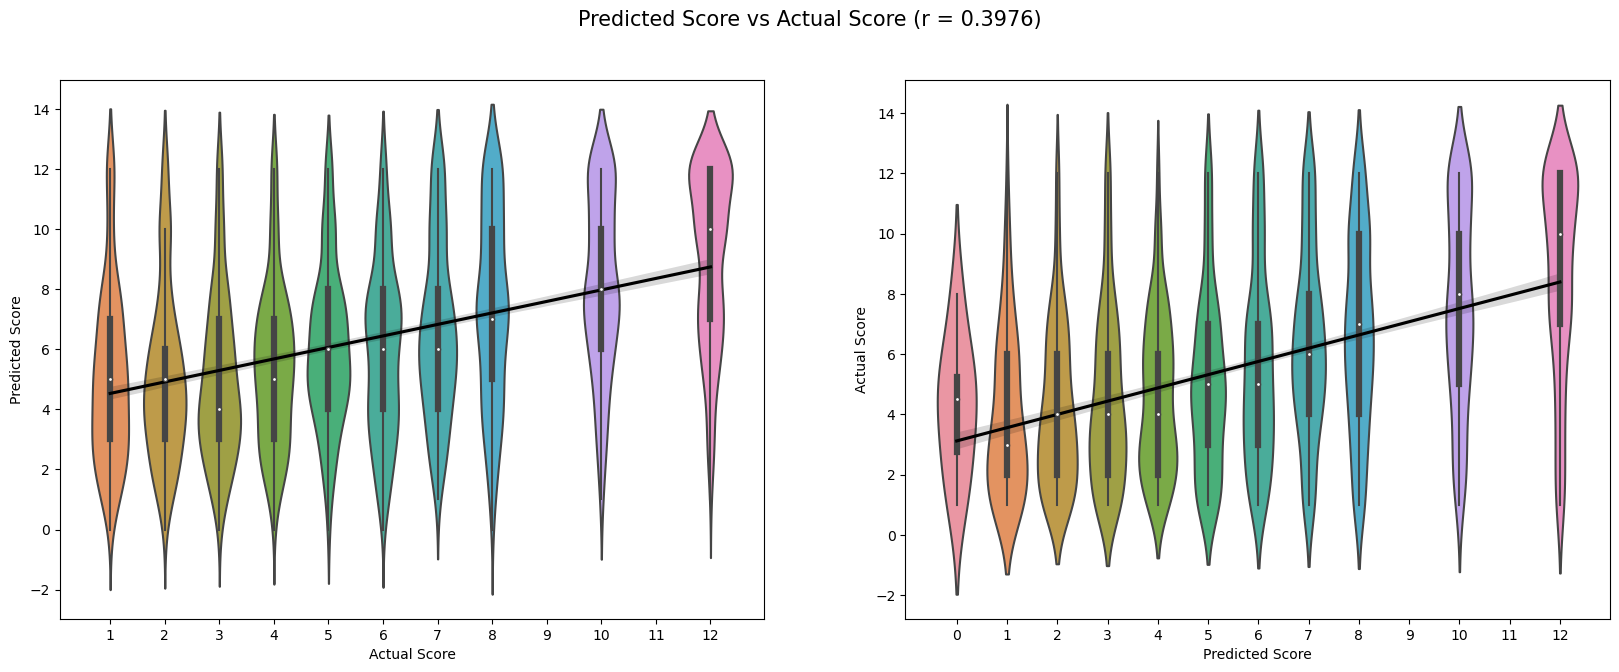

In [17]:
violins(out)

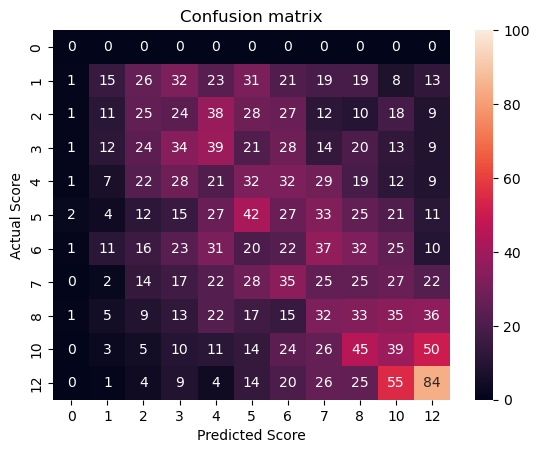

In [18]:
cm_heatmap(out)

See [here](https://discuss.xgboost.ai/t/evaluating-xgboost-ranking/959/2) for description of prediction scores

The 0 predictions are coming up when we have more that 10 non-zeroes (due to draws). So this actually works quite well I think. 

## Quickly see how this compares to a non pairwise rank model

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/2045035073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes["Votes"] - 1
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/2045035073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/2045035073.py:5: SettingWithCopyWarning: 
A value is trying to be set on

Accuracy: 13.42%


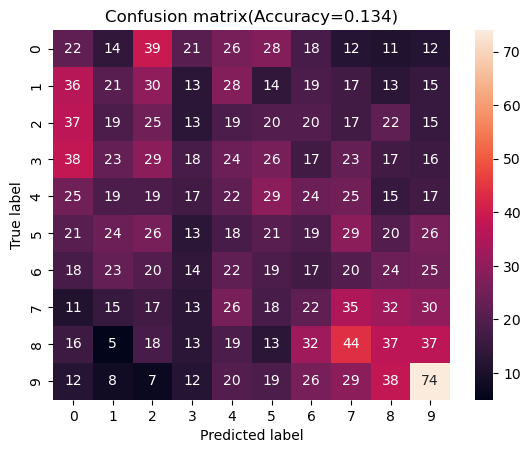

In [19]:
df_votes = df_xgboost.loc[df_xgboost['Votes'] > 0]

df_votes['Votes2'] = df_votes["Votes"] - 1
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 8 if x == 9 else x)
df_votes['Votes2'] = df_votes['Votes2'].apply(lambda x: 9 if x == 11 else x)

model, X_test, y_test, t2 = basic_xgboost(df_votes, seed=7, test_size=0.33, predictor_column='Votes2')
predictions = model_predictions(model, X_test, y_test)
model_evalutation(predictions)

In [20]:
predictions.head()

,Year,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,...,BY,GE,AZ,IT,ME,SM,AU,MK,predictions,actual
4433,2006,0.0,1.0,0.0,0.0,0.000276,50,1,0,0,...,0,0,0,0,0,0,0,0,8,3
11103,2015,1.0,1.0,0.0,0.0,0.000090,13,1,0,0,...,0,0,0,0,0,0,0,0,2,5
13420,2017,0.0,1.0,0.0,0.0,0.000815,1,0,0,1,...,0,0,0,0,0,0,0,0,7,0
7663,2010,1.0,0.0,0.0,0.0,0.001714,40,0,0,1,...,0,0,0,0,0,0,0,0,1,3
13884,2018,0.0,1.0,0.0,1.0,0.001728,3,0,0,1,...,0,0,0,0,0,0,0,0,9,4


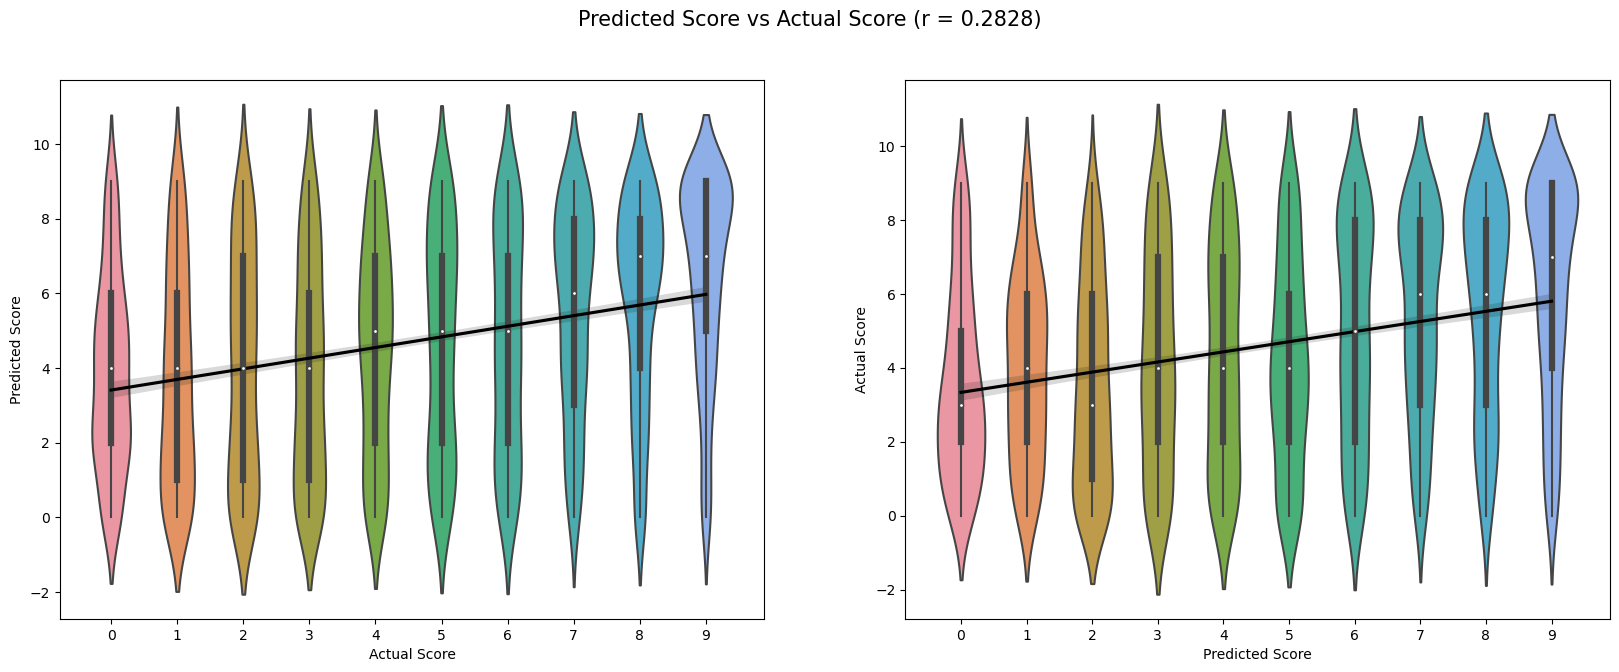

In [21]:
violins(predictions)

So, compared to the pairwise ranked version, this is not very good. 

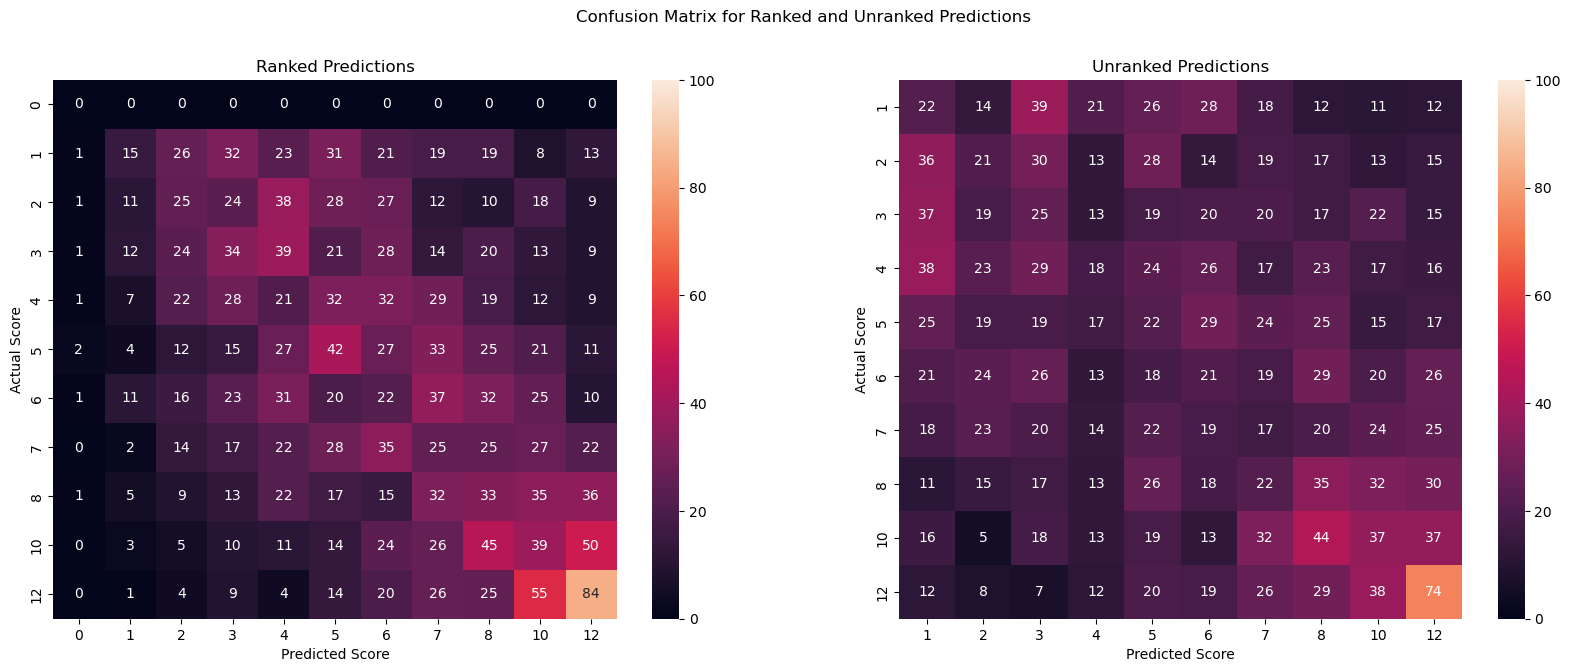

In [22]:
# ranked and unranked plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Confusion Matrix for Ranked and Unranked Predictions')

# ranked plot
cm_heatmap(out, title='Ranked Predictions', ax=ax1)
cm_heatmap(predictions, title='Unranked Predictions', ax=ax2)



# Combined the hurdle models

In [23]:
out.columns

Index(['Own', 'English', 'Other', 'has_border', 'prop_emigrants',
       'comps_since_last_win', 'group', 'female', 'male', 'BA',
       ...
       'AZ_voting', 'SM_voting', 'SK_voting', 'IT_voting', 'AU_voting', 'rank',
       'id', 'prediction_rel', 'predictions', 'actual'],
      dtype='object', length=106)

In [39]:
# hurdle 1 : did they get a score? 

model_basic, X_test, y_test, test_all = basic_xgboost(df_xgboost, seed=42, test_size=0.2)
predictions1 = model_predictions(model_basic, X_test, y_test)

predictions1['Votes'] = test_all['Votes']
predictions1.head()

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[i+j_text] = output_binary
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49940/1758629053.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,Year,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,...,BY,AZ,IT,ME,SM,AU,MK,predictions,actual,Votes
150,1999,1.0,1.0,0.0,0.0,0.000000,43,1,0,0,...,0,0,0,0,0,0,0,1,1,1.0
3465,2005,0.0,1.0,0.0,0.0,0.001878,5,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
8459,2011,0.0,1.0,0.0,0.0,0.001857,11,0,0,1,...,0,0,0,0,0,0,0,0,1,1.0
1547,2002,1.0,0.0,0.0,0.0,0.000702,46,1,0,0,...,0,0,0,0,0,0,0,0,1,2.0
903,2000,1.0,0.0,0.0,0.0,0.001297,11,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0


In [40]:
# hurdle 2 : if they did, what was the score?

hurdle_input = predictions1.loc[predictions1['actual'] > 0]
hurdle_input = hurdle_input.drop(columns=['predictions', 'actual'])
hurdle_input = hurdle_input.rename(columns={"Votes": 'rank'}).astype(int) 

# hurdle_input columns containing _voting
cols = [col for col in hurdle_input.columns if '_voting' in col]
cols2 = [col for col in hurdle_input.columns if '_voting' not in col]

# wide format _voting columns to long format
hurdle_input2 = pd.melt(hurdle_input, id_vars=cols2, 
                       value_vars= cols, var_name='From country')

hurdle_input2 = hurdle_input2.loc[hurdle_input2['value'] > 0]

# add hurdle_input2['From country'] to hurdle_input
hurdle_input['From country'] = hurdle_input2['From country'].str.replace('_voting', '').tolist()
hurdle_input['id'] = hurdle_input['From country'].astype(str) + hurdle_input['Year'].astype(str)

# remove From country column
hurdle_input = hurdle_input.drop(columns=['From country'])
hurdle_input = hurdle_input.drop(columns=['Year'])

hurdle_input.head()

,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,AT_voting,...,RS,BY,AZ,IT,ME,SM,AU,MK,rank,id
150,1,1,0,0,0,43,1,0,0,0,...,0,0,0,0,0,0,0,0,1,AT1999
8459,0,1,0,0,0,11,0,0,1,0,...,0,0,0,0,0,0,0,0,1,AT2011
1547,1,0,0,0,0,46,1,0,0,0,...,0,0,0,0,0,0,0,0,2,AT2002
14372,1,0,0,0,0,27,1,0,0,0,...,0,0,0,1,0,0,0,0,3,AT2018
11137,0,1,0,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,4,AT2015


In [41]:
hurdle_input[train_data.columns]

,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,rank,id,group,female,...,AM_voting,CZ_voting,GE_voting,ME_voting,RS_voting,AZ_voting,SM_voting,SK_voting,IT_voting,AU_voting
150,1,1,0,0,0,43,1,AT1999,1,0,...,0,0,0,0,0,0,0,0,0,0
8459,0,1,0,0,0,11,1,AT2011,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,1,0,0,0,0,46,2,AT2002,1,0,...,0,0,0,0,0,0,0,0,0,0
14372,1,0,0,0,0,27,3,AT2018,1,0,...,0,0,0,0,0,0,0,0,0,0
11137,0,1,0,0,0,5,4,AT2015,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7565,1,0,0,0,0,40,4,AU2010,0,0,...,0,0,0,0,0,0,0,0,0,0
8852,1,0,0,0,0,42,3,AU2012,0,1,...,0,0,0,0,0,0,0,0,0,0
4147,0,1,0,0,0,3,2,AU2006,1,0,...,0,0,0,0,0,0,0,0,0,0
8539,0,1,0,0,0,0,3,AU2011,0,1,...,0,0,0,0,0,0,0,0,0,0


In [42]:
predictions2 = ranked_model_predictions(model_ranked, hurdle_input[train_data.columns])

predictions2['predictions'].value_counts()


Accuracy: 1.77%


12.0    691
10.0    362
8.0     166
7.0      63
6.0      13
5.0       4
4.0       2
Name: predictions, dtype: int64

In [28]:
predictions2.head()

,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,rank,id,group,female,...,ME_voting,RS_voting,AZ_voting,SM_voting,SK_voting,IT_voting,AU_voting,prediction_rel,predictions,actual
11557,1,1,0,0,0,59,8,AT2015,0,0,...,0,0,0,0,0,0,0,1.0,12.0,9
13366,0,0,1,0,0,61,1,AT2017,0,0,...,0,0,0,0,0,1,0,1.0,5.0,2
10892,0,1,0,0,0,58,0,AT2014,1,0,...,0,0,0,0,0,0,0,3.0,12.0,1
6685,1,0,0,0,0,53,4,AT2009,0,1,...,0,0,0,0,0,0,0,1.0,12.0,5
13874,1,0,0,0,0,27,0,AT2018,1,0,...,0,0,0,0,0,0,0,1.0,10.0,1


In [29]:
predictions_final = predictions1.copy()

predictions_final['Score'] = predictions_final['predictions'].astype(int)

predictions_final.loc[predictions_final['predictions'] > 0, 'Score'] = predictions2['predictions'].astype(int)


print(predictions_final['Score'].value_counts())

predictions_final.head()

0     3213
12     806
10     525
8      287
7      152
6       72
5       25
4       11
3        5
1        2
2        2
Name: Score, dtype: int64


,Year,Own,English,Other,has_border,prop_emigrants,comps_since_last_win,group,female,male,...,AZ,IT,ME,SM,AU,MK,predictions,actual,Votes,Score
6020,2008,0.0,1.0,0.0,0.0,0.001591,25,1,0,0,...,0,0,0,0,0,0,0,0,0.0,0
11557,2015,1.0,1.0,0.0,0.0,0.000026,59,0,0,1,...,0,0,0,0,1,0,1,1,8.0,12
8810,2012,0.0,1.0,0.0,0.0,0.000050,0,0,1,0,...,1,0,0,0,0,0,0,0,0.0,0
4626,2007,1.0,1.0,0.0,0.0,0.000137,10,1,0,0,...,0,0,0,0,0,0,0,0,0.0,0
13366,2017,0.0,0.0,1.0,0.0,0.000730,61,0,0,1,...,0,0,0,0,0,0,1,1,1.0,5


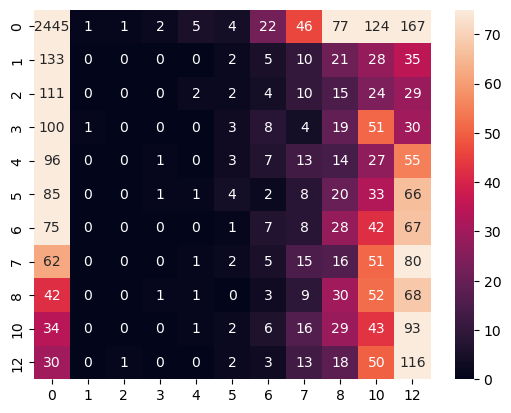

In [30]:
# confusion matrix for hurdle model


cm = confusion_matrix(predictions_final['Votes'], predictions_final['Score'])
plot = sns.heatmap(cm, annot=True, fmt='g', vmin=0, vmax=75)

if(len(cm[[0]][0]) == 11) : 
# change the tick labels
    plot.set_xticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 11, 1)+0.5, np.arange(0, 9, 1).tolist() + [10, 12])
else: 
    plot.set_xticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])
    plot.set_yticks(np.arange(0, 10, 1)+0.5, np.arange(1, 9, 1).tolist() + [10, 12])

plot.set_title(title)
plot.set_ylabel('Actual Score')
plot.set_xlabel('Predicted Score')

plt.show()
